## **introduction**

The purpose of the project is to diagnose plant diseases solely based on leaf images. The categories include "healthy", "scab", "rust", and "multiple diseases".
 Solving this problem is important because diagnosing plant diseases early can save tonnes of agricultural produce every year. This will benefit not only the general population by reducing hunger, but also the farmers by ensuring they get the harvest they deserve.

The project is based on the data set "[Plant Pathology 2020 - FGVC7](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)" Contains 3642 images of apple leaves divided into training data and test data.

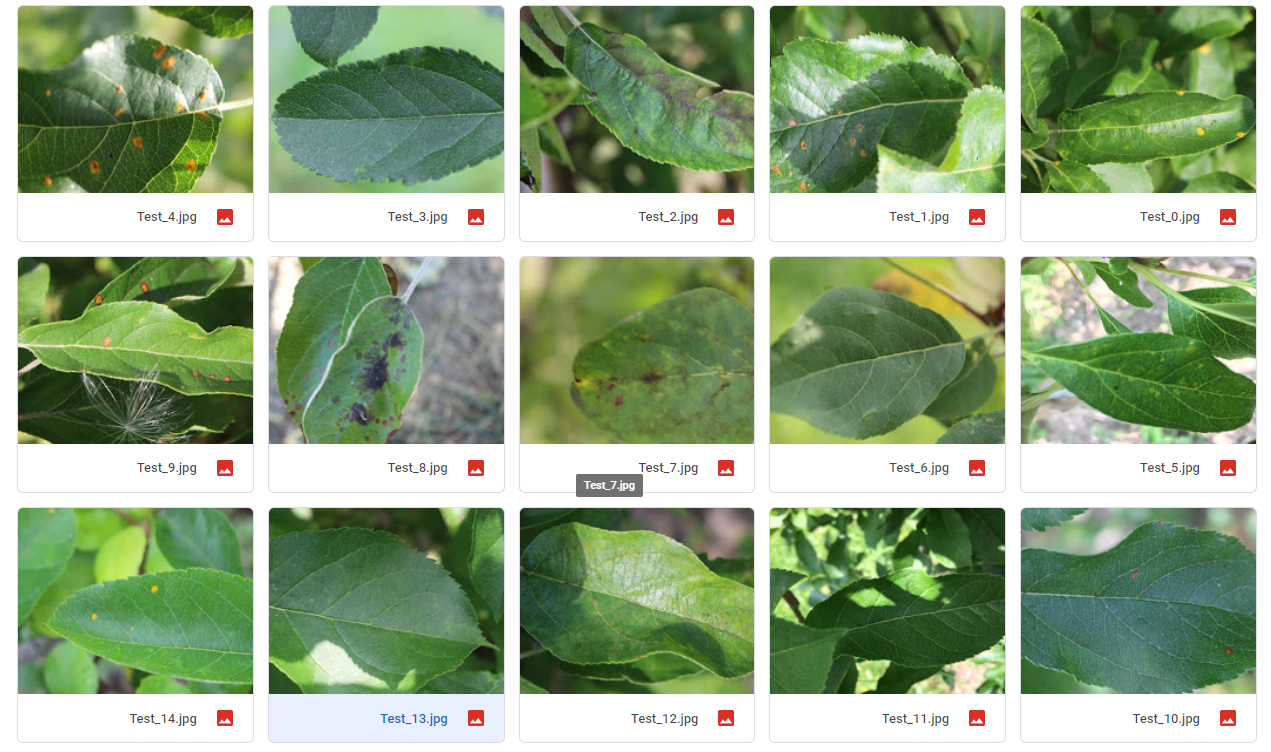


# **Project's Target**
Our goal is to produce a model that classify correcly the health of a leaf and can say in great confidence what disease does it have.

# **Install and Import Necessary Libraries**

In [1]:
!pip install -q efficientnet


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import cv2
from google.colab.patches import cv2_imshow

from tqdm.notebook import tqdm
tqdm.pandas()

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
import keras

from keras.models import Model, Sequential, load_model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



#**Data Loading and Constant Declaring** 

In [6]:
IMAGE_PATH = "/content/drive/My Drive/Apple-class/Data/images/"
TRAIN_PATH = "/content/drive/My Drive/Apple-class/Data/train.csv"
SUB_PATH = '/content/drive/My Drive/Apple-class/Data/sample_submission.csv'
n_sample=100
seed=2020

sub = pd.read_csv(SUB_PATH)
train_data = pd.read_csv(TRAIN_PATH)

#**Functions**

In [7]:
#print a image
def show_image(img):
  fig = plt.imshow(img)

#loads a image from the disk and returns it 
def load_image(image_id,image_size=(100,100)):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path,1)
    image = cv2.resize(image, image_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

#creat from image list a 4d array of the data
def images_4d_array(files_list):
  images_list = [img[np.newaxis, :, :, :3] for img in files_list]
  images_array = np.vstack(images_list)
  return (images_array)

#retrive a list of images that fullfil the cond cond is a column name, and show 9 pics of them
def show_cond(cond):
  cond_list=train_images[train_data[cond]==1]
  cols, rows = 3,3  
  fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
  for i in range(cols*rows):
    if(i>=cond_list.size):
      break
    ax[int(i/cols), int(i%rows)].imshow(cond_list.iloc[i])
  plt.show()
  return (cond_list)

#retrive a list of images that fullfil the cond cond is a column name
def get_cond(cond):
  cond_list=train_images[train_data[cond]==1] 
  return (cond_list)

#get the avarge per color channel
def get_average_channel(x, channel):
    return x[:,:,:,channel].mean(axis = (1, 2)).reshape(-1, 1)

#get the avarge per color channel for all photos, gets a 4D array
def get_channels(x):
    return np.hstack([get_average_channel(x, i) for i in range(3)])

#changes the 4d array into 2d array
def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

#merges images so they can be printed together
def merge_images(image_batch, size = [20, 20]):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im/255
    return img

# returns an array of numerated classes
def get_target_array(data):
  targets=[]
  for index, row in data.drop('image_id',axis=1).iterrows():
    if (row[0]==1):
      targets.append(0)
    elif (row[1]==1):
      targets.append(1)
    elif (row[2]==1):
      targets.append(2)
    elif (row[3]==1):
      targets.append(3)
  return (np.array(targets))

# **Data Exploration and Analysis**

We should explore our data and check what classes and data we have

In [8]:
print(train_data.head(),train_data.shape)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0 (1821, 5)


As can be seen, we have a list of images and their class out of 4, healthy, multiple_diseases, rust and scab. We have 1821 images, lets find the distribution of the data

healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


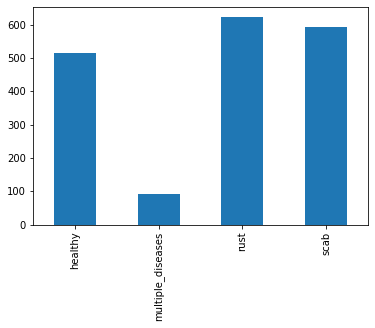

In [9]:
data_sum = train_data.drop('image_id',axis=1).sum()
print(data_sum)
data_sum.plot.bar()

The multiple_diseases is highly underrepresented. Our data is imbalanced and that can effect us. 

# **Load Images**

We will load random sample of images 

In [10]:
#loads all of the images
train_images = train_data["image_id"].progress_apply(load_image, args=((100,100),))

#load a random sample
#train_images = train_data["image_id"].sample(n = n_sample, random_state = seed).progress_apply(load_image)

#Build the dataset of current images
current_train_data=train_data.loc[train_images.index]
targets=get_target_array(current_train_data)

Lets see some pictures from each class

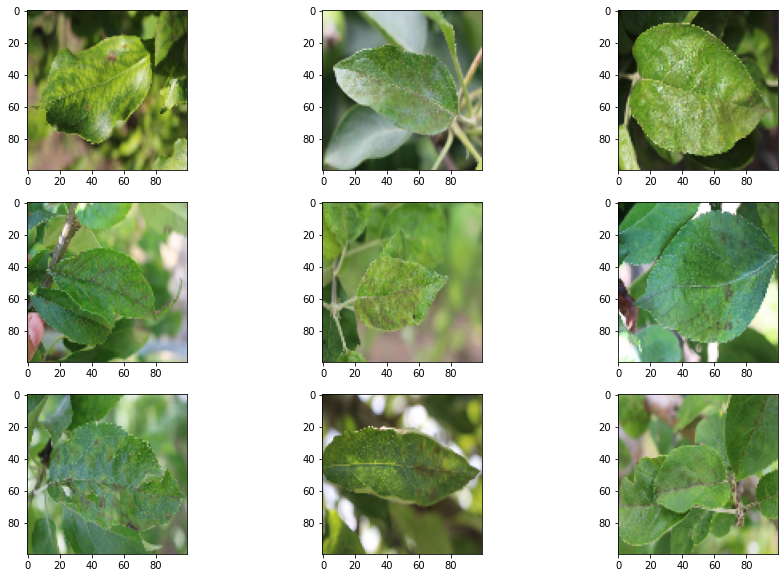

In [11]:
scab_list=show_cond('scab') 

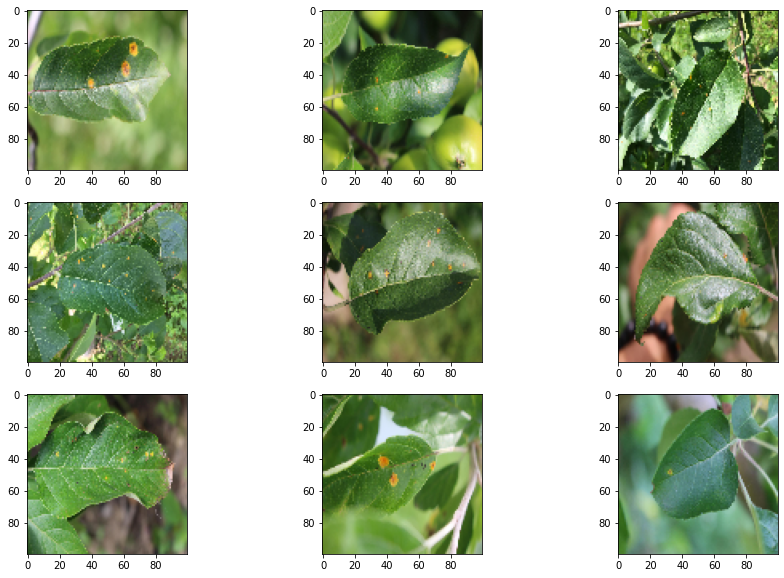

In [12]:
rust_list=show_cond('rust')

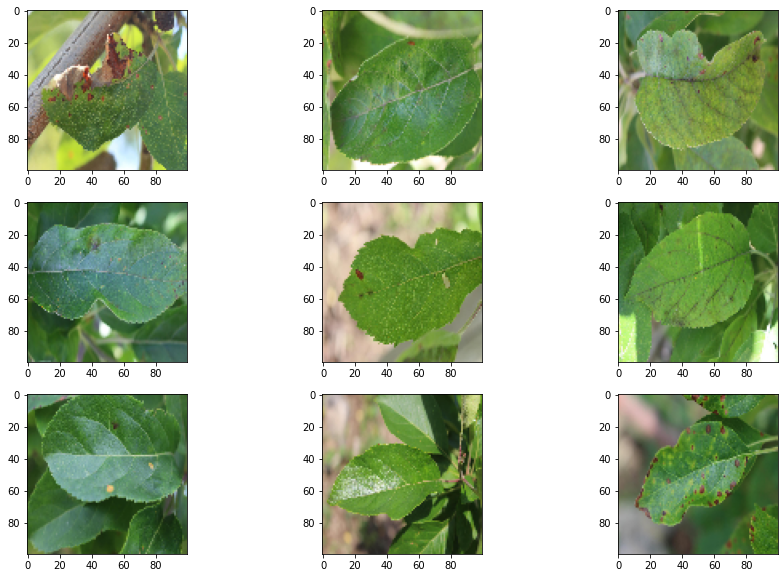

In [13]:
multi_list=show_cond('multiple_diseases')

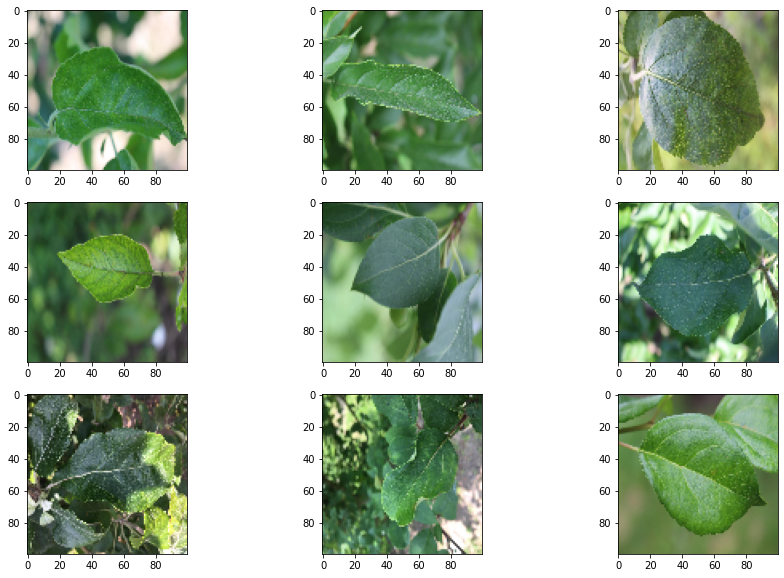

In [14]:
healthy_list=show_cond('healthy')

#**Color Analysis**

Changing the pictures array to 4D array so we could analyze them 

In [15]:
healthy_array=images_4d_array(healthy_list)
scab_array=images_4d_array(scab_list)
multi_array=images_4d_array(multi_list)
rust_array=images_4d_array(rust_list)

print(healthy_array.shape,scab_array.shape,multi_array.shape,rust_array.shape)

(516, 100, 100, 3) (592, 100, 100, 3) (91, 100, 100, 3) (622, 100, 100, 3)


Colors in pictures are the basic features, thus analyising them is our first step. Lets plot the color histograms for each class

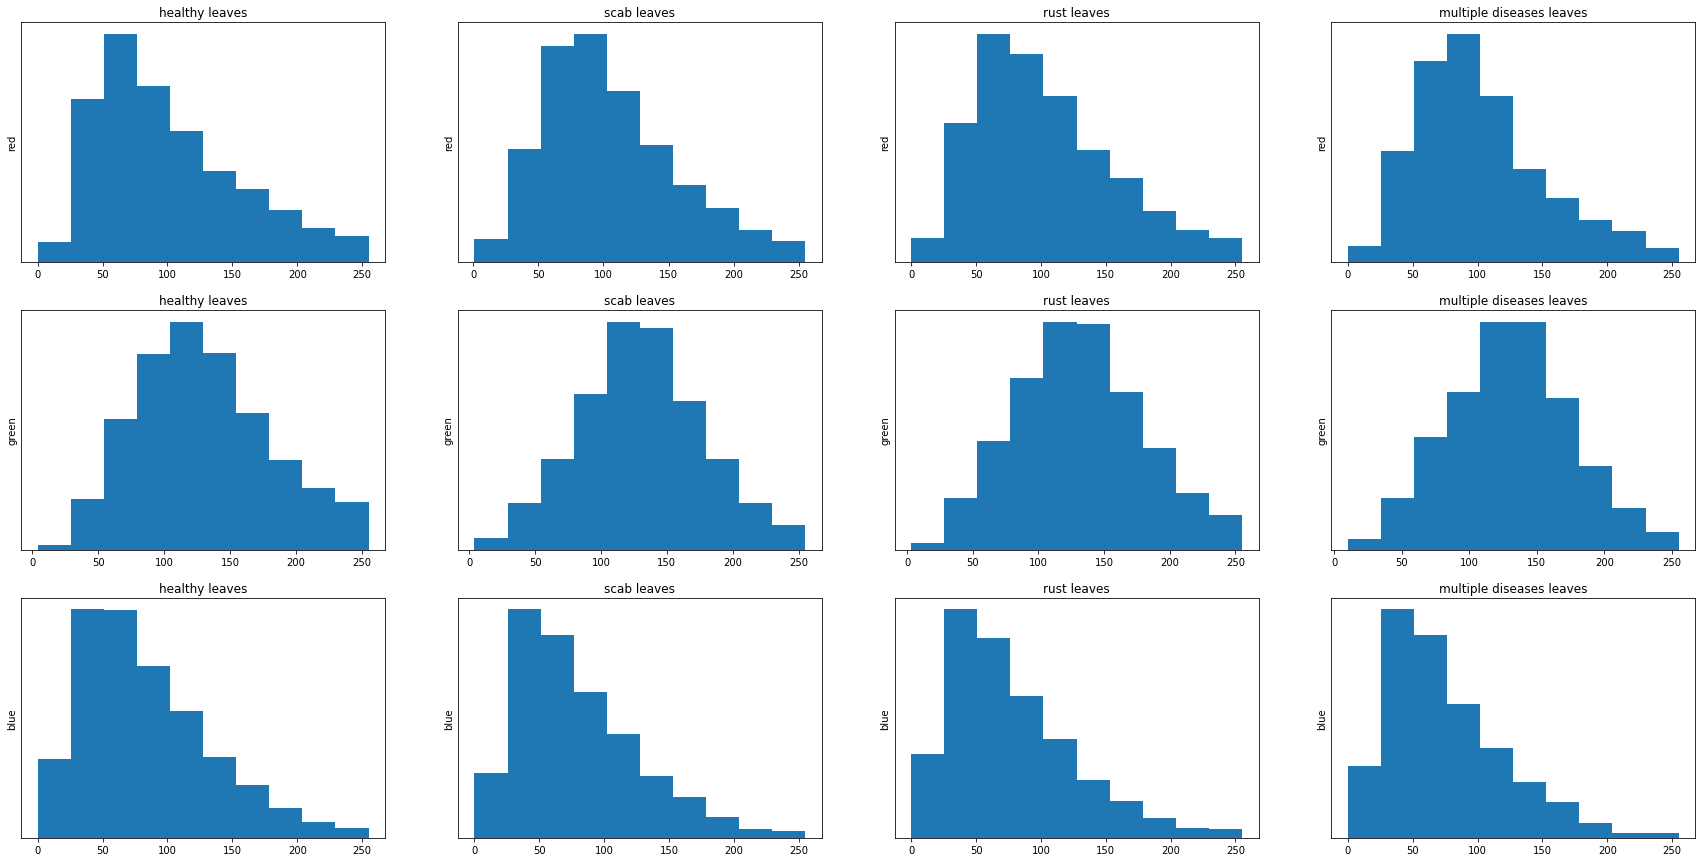

In [16]:
#print histograms of colors
def plot_hist_normed(images, channel, col):
    vals = images[:,:,:,channel].flatten()
    plt.ylabel(col)
    plt.hist(vals)
    plt.yticks([])


#red  
plt.figure(figsize =(30, 15))
plt.subplot(3, 4, 1)
plot_hist_normed(healthy_array, 0, 'red')
plt.title('healthy leaves')
plt.subplot(3, 4, 2)
plot_hist_normed(scab_array, 0, 'red')
plt.title('scab leaves')
plt.subplot(3, 4, 3)
plot_hist_normed(rust_array, 0, 'red')
plt.title('rust leaves')
plt.subplot(3, 4, 4)
plot_hist_normed(multi_array, 0, 'red')
plt.title('multiple diseases leaves')

#green
plt.subplot(3, 4, 5)
plot_hist_normed(healthy_array, 1, 'green')
plt.title('healthy leaves')
plt.subplot(3, 4, 6)
plot_hist_normed(scab_array, 1, 'green')
plt.title('scab leaves')
plt.subplot(3, 4, 7)
plot_hist_normed(rust_array, 1, 'green')
plt.title('rust leaves')
plt.subplot(3, 4, 8)
plot_hist_normed(multi_array, 1, 'green')
plt.title('multiple diseases leaves')

#blue
plt.subplot(3, 4, 9)
plot_hist_normed(healthy_array, 2, 'blue')
plt.title('healthy leaves')
plt.subplot(3, 4, 10)
plot_hist_normed(scab_array, 2, 'blue')
plt.title('scab leaves')
plt.subplot(3, 4, 11)
plot_hist_normed(rust_array, 2, 'blue')
plt.title('rust leaves')
plt.subplot(3, 4, 12)
plot_hist_normed(multi_array, 2, 'blue')
plt.title('multiple diseases leaves')


plt.show()

Lest plot the mean and median values for the classes

In [17]:
def summary(images, channel, col):
    vals = images[:,:,:,channel].flatten()
    chan_mean = np.mean(vals)
    chan_median = np.median(vals)
    print('{} mean: {}, median: {}'.format(col, str(chan_mean), str(chan_median)))

print('healthy leaves:')
summary(healthy_array, 0, 'red')
summary(healthy_array, 1, 'green')
summary(healthy_array, 2, 'blue')
print('scab leaves:')
summary(scab_array, 0, 'red')
summary(scab_array, 1, 'green')
summary(scab_array, 2, 'blue')
print('rust leaves:')
summary(rust_array, 0, 'red')
summary(rust_array, 1, 'green')
summary(rust_array, 2, 'blue')
print('multiple diseases leaves:')
summary(multi_array, 0, 'red')
summary(multi_array, 1, 'green')
summary(multi_array, 2, 'blue')


healthy leaves:
red mean: 100.57084709302326, median: 88.0
green mean: 130.19105174418604, median: 125.0
blue mean: 83.54324341085271, median: 73.0
scab leaves:
red mean: 105.11685692567568, median: 96.0
green mean: 130.62996638513513, median: 130.0
blue mean: 79.29660625, median: 69.0
rust leaves:
red mean: 102.82335562700965, median: 93.0
green mean: 131.2191961414791, median: 129.0
blue mean: 77.54976221864952, median: 67.0
multiple diseases leaves:
red mean: 101.78078351648351, median: 93.0
green mean: 130.30196043956045, median: 131.0
blue mean: 75.38068461538461, median: 65.0


As can be seen the blue channels mean and median of the diseased leaves are lower, and the red channels mean and median are higher then the healthy ones. We should explore the difference further by comparing the healty and diseased leaves pictures

In [18]:
diseased_leaves_array=np.concatenate((rust_array,multi_array,scab_array))
diseased_leaves_array.shape

(1305, 100, 100, 3)

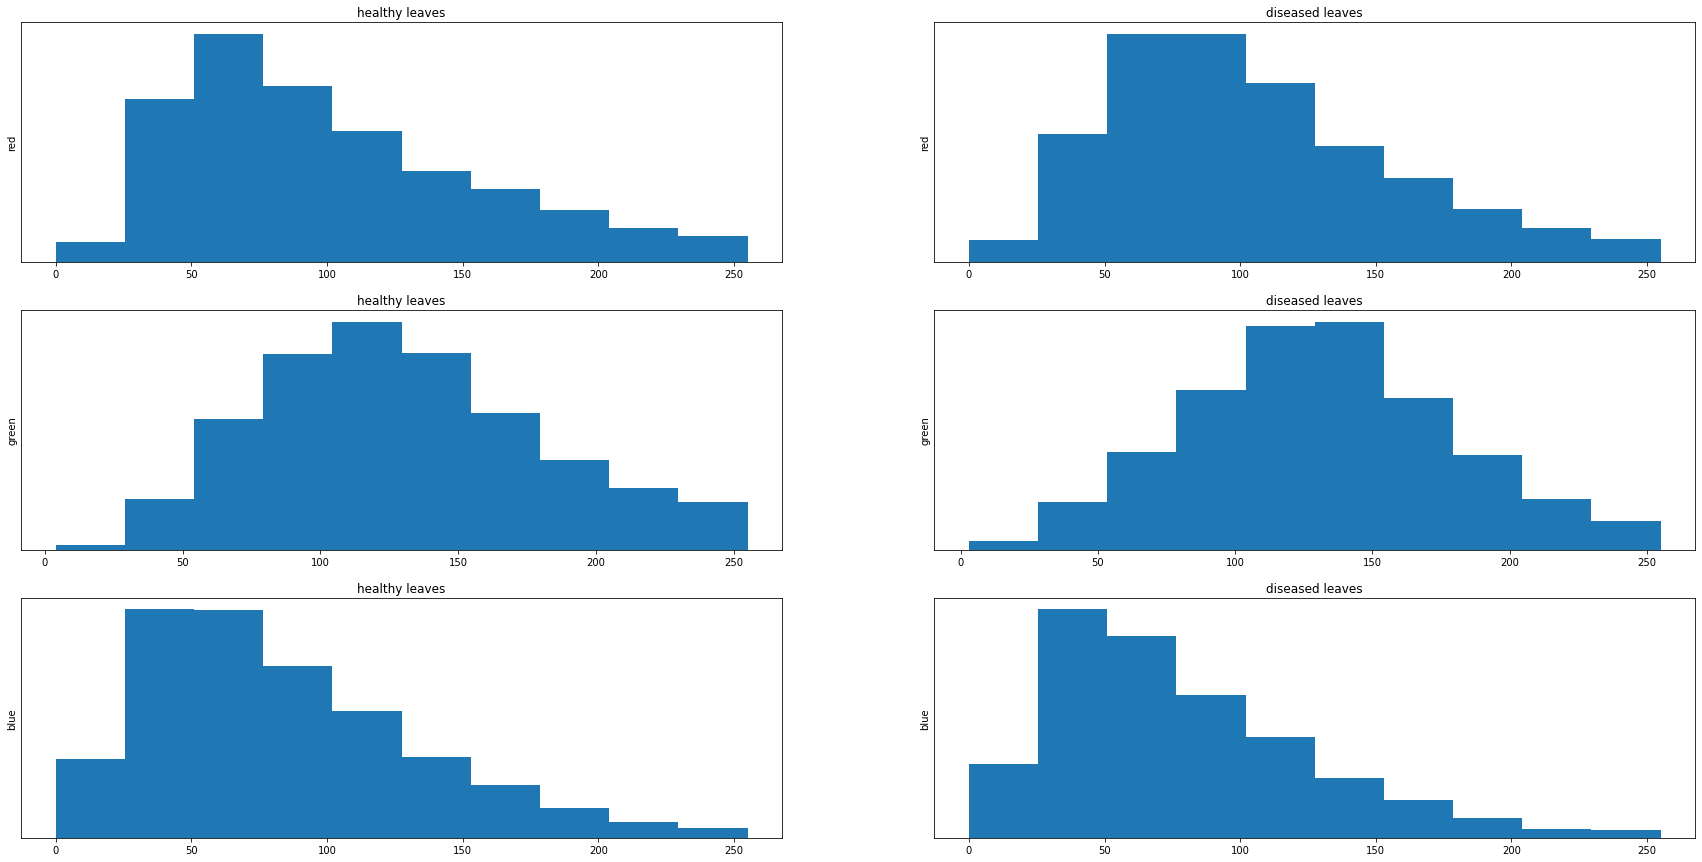

healthy leaves:
red mean: 100.57084709302326, median: 88.0
green mean: 130.19105174418604, median: 125.0
blue mean: 83.54324341085271, median: 73.0
diseased leaves:
red mean: 103.79107877394637, median: 95.0
green mean: 130.88793754789273, median: 129.0
blue mean: 78.19094659003831, median: 67.0


In [19]:
#red  
plt.figure(figsize =(30, 15))
plt.subplot(3, 2, 1)
plot_hist_normed(healthy_array, 0, 'red')
plt.title('healthy leaves')
plt.subplot(3, 2, 2)
plot_hist_normed(diseased_leaves_array, 0, 'red')
plt.title('diseased leaves')

#green
plt.subplot(3, 2, 3)
plot_hist_normed(healthy_array, 1, 'green')
plt.title('healthy leaves')
plt.subplot(3, 2, 4)
plot_hist_normed(diseased_leaves_array, 1, 'green')
plt.title('diseased leaves')

#blue
plt.subplot(3, 2, 5)
plot_hist_normed(healthy_array, 2, 'blue')
plt.title('healthy leaves')
plt.subplot(3, 2, 6)
plot_hist_normed(diseased_leaves_array, 2, 'blue')
plt.title('diseased leaves')

plt.show()


print('healthy leaves:')
summary(healthy_array, 0, 'red')
summary(healthy_array, 1, 'green')
summary(healthy_array, 2, 'blue')
print('diseased leaves:')
summary(diseased_leaves_array, 0, 'red')
summary(diseased_leaves_array, 1, 'green')
summary(diseased_leaves_array, 2, 'blue')

As we expected the blue values are lower and the red values are higher. We can see that the diseased leaves have brown or yellow spots on them. That might be the reason for the discrepancy as in those colors the blue channel has a lower value and the red color has a higher value, and if that is the reason, those differences might help us to identify the healthy leaves. This hypothesis is bold and in order to try and see if it has any truth in it more exploration is needed


# **PCA**

We want to further explore the main difference between the classes, and to try and check our hypothesis. Principal component analysis is an effective way to do so. First we will arrange the data so it will be easier to analyse it

In [20]:
images_array=images_4d_array(train_images)
images_array_all = get_all_pixels(images_array)

Compute the first 5 PCs and the projection on them

In [21]:
images_array_all_centered=StandardScaler().fit_transform(images_array_all)

pca = PCA(n_components = 5)
pca.fit(images_array_all_centered)
x_train_reduced = pca.transform(images_array_all_centered)
principalDf=pd.DataFrame(data=x_train_reduced,columns=['PC 1','PC 2','PC 3','PC 4','PC 5'] )
principalDf.head()

PC 1       PC 2       PC 3       PC 4       PC 5
0 -49.045667  -3.203598  38.346776 -32.222319 -47.354734
1  75.236755 -38.887469 -17.940787  -5.531354 -21.273726
2  87.868457  33.497381   1.978227  20.718745   2.647148
3  34.109784  27.229476  33.881236 -61.139745  28.570935
4 -38.610821   8.065908  -9.296282  15.759031  19.698962

Lets plot the data on the first 2 PCs 

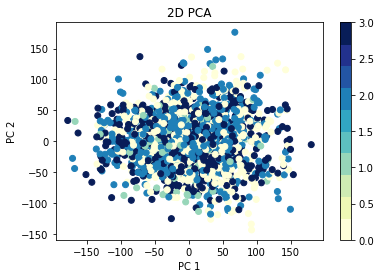

In [22]:
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D PCA')
plt.scatter(x_train_reduced[:, 0], x_train_reduced[:, 1],c = targets, cmap=plt.cm.get_cmap('YlGnBu', 10))
plt.colorbar();

The dispersal of data does not correspond with 4 classes or some kind of clusters, which suggests that the PCs does not discribe the difference in the classes. Since we're dealing with images the best way to get what a given PC's "subject", what it discribes, is  simply to view those images which have a high or low score for this PC.


## First PC

First we should find the top and bottom 16 images in the PC

In [23]:
highest_score_ids = np.argpartition(x_train_reduced[:, 0], -16)[-16:]
lowest_score_ids = np.argpartition(x_train_reduced[:, 0], 16)[:16]

Now, we will print the classification of them, maybe the this could tell us something

In [24]:
print(current_train_data.iloc[highest_score_ids])
print(current_train_data.iloc[lowest_score_ids])

        image_id  healthy  multiple_diseases  rust  scab
1500  Train_1500        0                  0     0     1
598    Train_598        0                  0     1     0
977    Train_977        1                  0     0     0
213    Train_213        1                  0     0     0
42      Train_42        0                  0     0     1
823    Train_823        0                  0     0     1
630    Train_630        1                  0     0     0
1240  Train_1240        1                  0     0     0
1212  Train_1212        0                  0     0     1
1211  Train_1211        0                  0     0     1
1467  Train_1467        0                  0     0     1
38      Train_38        0                  0     1     0
127    Train_127        0                  0     0     1
1207  Train_1207        0                  0     1     0
891    Train_891        0                  0     0     1
810    Train_810        0                  0     0     1
        image_id  healthy  mult

There isn't a clear difference betweet the groups

Lets print the images and check if the difference can be identify

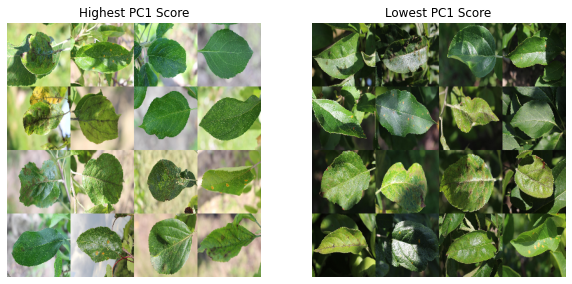

In [25]:
highest_images_4d=images_array[highest_score_ids]
lowest_images_4d=images_array[lowest_score_ids]

highest_images_merged = merge_images(highest_images_4d, size = [4, 4])
lowest_images_merged = merge_images(lowest_images_4d, size = [4, 4])

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC1 Score')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC1 Score')
plt.axis('off')
plt.imshow(lowest_images_merged)

From the images we can infer that the first PC is about the background color. The highest images have brighter brackgraoud, and the lowest have darker background 

## Second PC




We will repeat the process

        image_id  healthy  multiple_diseases  rust  scab
977    Train_977        1                  0     0     0
317    Train_317        1                  0     0     0
1449  Train_1449        1                  0     0     0
130    Train_130        0                  0     0     1
188    Train_188        0                  0     1     0
535    Train_535        0                  1     0     0
500    Train_500        0                  0     1     0
1556  Train_1556        1                  0     0     0
647    Train_647        0                  0     1     0
181    Train_181        0                  0     1     0
1654  Train_1654        1                  0     0     0
510    Train_510        0                  0     1     0
1677  Train_1677        0                  0     1     0
1702  Train_1702        0                  0     0     1
421    Train_421        1                  0     0     0
1275  Train_1275        0                  0     1     0
        image_id  healthy  mult

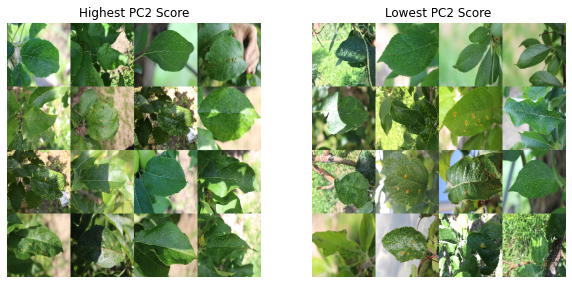

In [26]:
highest_score_ids = np.argpartition(x_train_reduced[:, 1], -16)[-16:]
lowest_score_ids = np.argpartition(x_train_reduced[:, 1], 16)[:16]
print(current_train_data.iloc[highest_score_ids])
print(current_train_data.iloc[lowest_score_ids])
highest_images_4d=images_array[highest_score_ids]
lowest_images_4d=images_array[lowest_score_ids]

highest_images_merged = merge_images(highest_images_4d, size = [4, 4])
lowest_images_merged = merge_images(lowest_images_4d, size = [4, 4])

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC2 Score')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC2 Score')
plt.axis('off')
plt.imshow(lowest_images_merged)

There isn't a clear difference between the groups' classes. From the imags we can infer that the difference is again in the background's shap and lighting changes

## Third PC




We will repeat the process

        image_id  healthy  multiple_diseases  rust  scab
1017  Train_1017        1                  0     0     0
1280  Train_1280        0                  1     0     0
1351  Train_1351        0                  0     1     0
1726  Train_1726        0                  0     1     0
1263  Train_1263        0                  0     1     0
138    Train_138        0                  0     0     1
1674  Train_1674        0                  0     1     0
1011  Train_1011        0                  0     1     0
1330  Train_1330        0                  0     1     0
745    Train_745        0                  0     1     0
996    Train_996        0                  0     1     0
1391  Train_1391        1                  0     0     0
302    Train_302        0                  0     1     0
899    Train_899        0                  0     0     1
574    Train_574        0                  0     1     0
268    Train_268        0                  0     0     1
        image_id  healthy  mult

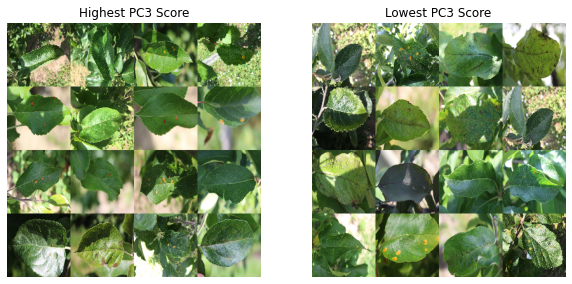

In [27]:
highest_score_ids = np.argpartition(x_train_reduced[:, 2], -16)[-16:]
lowest_score_ids = np.argpartition(x_train_reduced[:, 2], 16)[:16]
print(current_train_data.iloc[highest_score_ids])
print(current_train_data.iloc[lowest_score_ids])
highest_images_4d=images_array[highest_score_ids]
lowest_images_4d=images_array[lowest_score_ids]

highest_images_merged = merge_images(highest_images_4d, size = [4, 4])
lowest_images_merged = merge_images(lowest_images_4d, size = [4, 4])

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC3 Score')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC3 Score')
plt.axis('off')
plt.imshow(lowest_images_merged)

There isn't a clear difference between the groups' classes. It is hard to infer from the images what features are promenent in this PC.

## Forth PC




We will repeat the process

        image_id  healthy  multiple_diseases  rust  scab
919    Train_919        1                  0     0     0
1586  Train_1586        0                  0     0     1
914    Train_914        1                  0     0     0
909    Train_909        1                  0     0     0
1193  Train_1193        1                  0     0     0
937    Train_937        1                  0     0     0
976    Train_976        0                  0     1     0
1347  Train_1347        1                  0     0     0
772    Train_772        1                  0     0     0
1687  Train_1687        1                  0     0     0
367    Train_367        1                  0     0     0
88      Train_88        1                  0     0     0
1661  Train_1661        1                  0     0     0
815    Train_815        1                  0     0     0
219    Train_219        1                  0     0     0
341    Train_341        0                  0     1     0
        image_id  healthy  mult

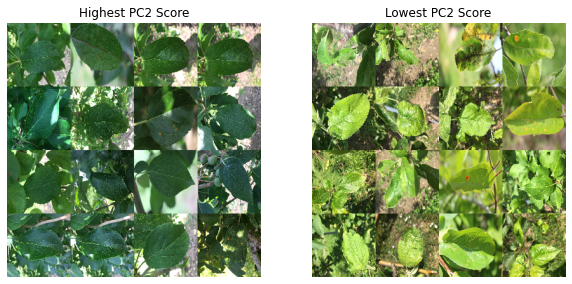

In [28]:
highest_score_ids = np.argpartition(x_train_reduced[:, 3], -16)[-16:]
lowest_score_ids = np.argpartition(x_train_reduced[:, 3], 16)[:16]
print(current_train_data.iloc[highest_score_ids])
print(current_train_data.iloc[lowest_score_ids])
highest_images_4d=images_array[highest_score_ids]
lowest_images_4d=images_array[lowest_score_ids]

highest_images_merged = merge_images(highest_images_4d, size = [4, 4])
lowest_images_merged = merge_images(lowest_images_4d, size = [4, 4])

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC2 Score')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC2 Score')
plt.axis('off')
plt.imshow(lowest_images_merged)

There isn't a clear difference between the groups' classes. From the imags we can infer that the difference is in the color of the images, the highest group is has darker and less yellowish leaves and the lowest group has bighterand yellowish leaves which is the result of the sorce of lighting and not the different classes 

## Conclusin Thus Far

This lead of exploration didn't bear fruits, but we learned that the main difference in the images stamps from the difference in lighting in the images. The color difference that we have found between the classes probably was created as a result of those changes and doesn't corresponds to real differences in the classes 

#**K-Mean Clustering**

Lets try a different approach, even though we have the classification of every sample, we can try and check if the data is scattered around 4 clusters of the classes

In [29]:
kmeans= KMeans(n_clusters=4)

## Mean Pixel Value

Firstly we will try to use a single value for each picture, its mean pixel value

In [30]:
avarage_pixel=images_array_all.mean(axis=1).reshape(-1, 1)
kmeans.fit(avarage_pixel)
data_kmeans=kmeans.predict(avarage_pixel)

The classification number will not correspond with the 4 clustering classes, so we will just check if the clustering classes are divided in a way that can be aligned with the classes

In [31]:
labels=np.zeros_like(data_kmeans)
for i in range(4):
  mask=(data_kmeans==i)
  labels[mask]=(i)%4

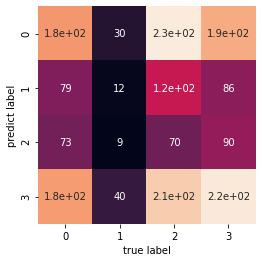

In [32]:
mat = confusion_matrix(targets,labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');

As can be seen from the confusion matrix most of the predictions are all over the place and didn't converge into one classification for each class.

## Mean Channel Value

Now we will try to use a 3 channel mean value for image

In [33]:
avarage_pixel_channels=get_channels(images_array)


In [34]:
kmeans.fit(avarage_pixel_channels)
data_kmeans=kmeans.predict(avarage_pixel_channels)
print(data_kmeans)

[2 0 0 ... 0 1 3]


The classification number will not correspond with the 4 clustering classes, so we will just check if the clustering classes are divided in a way that can be aligned with the classes

In [35]:
labels=np.zeros_like(data_kmeans)
for i in range(4):
  mask=(data_kmeans==i)
  labels[mask]=(i)%4

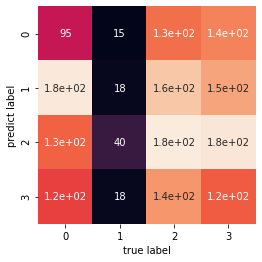

In [36]:
mat = confusion_matrix(targets,labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');

As can be seen from the confusion matrix most of the predictions are all over the place and didn't converge into one classification for each class.

## All Channel Values

Now we will try to use all of the channel values

In [37]:
kmeans.fit(images_array_all)
data_kmeans=kmeans.predict(images_array_all)
print(data_kmeans)

[2 3 3 ... 3 1 2]


The classification number will not correspond with the 4 clustering classes, so we will just check if the clustering classes are divided in a way that can be aligned with the classes

In [38]:
labels=np.zeros_like(data_kmeans)
for i in range(4):
  mask=(data_kmeans==i)
  labels[mask]=(i)%4

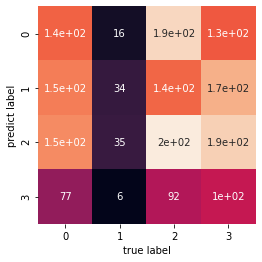

In [39]:
mat = confusion_matrix(targets,labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');

As can be seen from the confusion matrix most of the predictions are all over the place and didn't converge into one classification for each class.

## Conclusin Thus Far

We saw that the data is not seperated into 4 clusters that corispont to their class. Its seems that the data seperation does not corispond to the classes, parhaps the fine details that separate the classes needs a more robust method to get unveiled

#**Logistic Regression**

As we already established, the data is not scatered in a way that can differ easily the classe. In our next attempt we would try to create a logistic regression that we classify images base of the values.

Firstly, we would separate the data to train and test, we chose to use a standard 80-20 split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(images_array, targets, test_size=0.2, random_state=seed)
X_train_2d=get_all_pixels(X_train)
X_test_2d=get_all_pixels(X_test)

In [41]:
print(X_train_2d.shape, X_test_2d.shape, y_train.shape, y_test.shape)

(1456, 30000) (365, 30000) (1456,) (365,)


## Mean Pixel Value

As previously we will try first the simplest evaluation method, the mean pixel value 

In [42]:
avarage_pixel_train=X_train_2d.mean(axis=1).reshape(-1, 1)
avarage_pixel_test=X_test_2d.mean(axis=1).reshape(-1, 1)

In [43]:
lrf=LogisticRegression()
lrf.fit(avarage_pixel_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Lets print the histogram of probabilities for each class

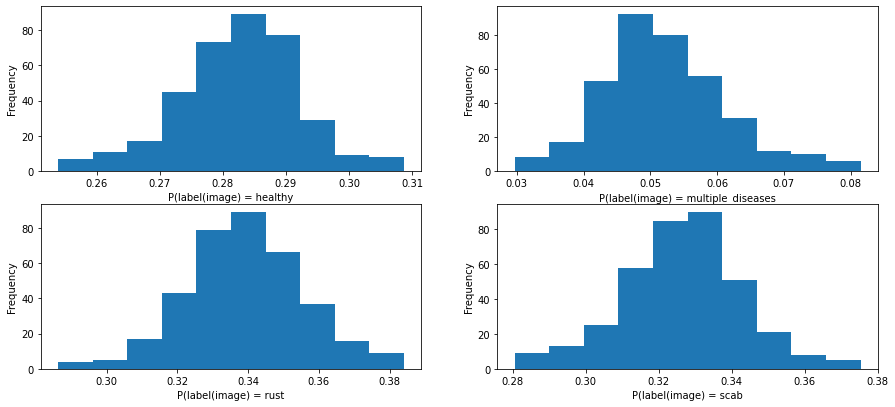

In [44]:
y_pred_prob = lrf.predict_proba(avarage_pixel_test)

cols, rows = 2,2  
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for i in range(cols*rows):
  ax[int(i/cols), int(i%rows)].hist(y_pred_prob[:, i])
  plt.setp(ax[int(i/cols), int(i%rows)], xlabel=f'P(label(image) = {current_train_data.columns[i+1]}')
  plt.setp(ax[int(i/cols), int(i%rows)], ylabel='Frequency')
plt.show()

The histogram above tells us that our predictions are not good, the confidence of the classifications is low, and not a single image is classified in a probability of more then 40%.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.00      0.00      0.00        17
           2       0.35      0.63      0.45       129
           3       0.30      0.35      0.32       115

    accuracy                           0.33       365
   macro avg       0.16      0.24      0.19       365
weighted avg       0.22      0.33      0.26       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



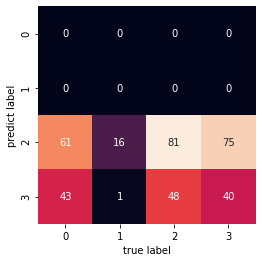

In [45]:
y_pred = lrf.predict(avarage_pixel_test)
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');
print(classification_report(y_test, y_pred))

Our model prediction accuracy is abysmal, the model failed to classify leaves as healthy or as having 2 diseases. The 33% accuracy looks a bit better than guessing, but in considerring of our imbalanced data set the accuracy seems as a lazy student in a multiple choice test

## Mean Channel Values

Our next step is to try the next simplest method, the mean channel values for every image

In [46]:
X_train_avarage_pixel_channels=get_channels(X_train)
X_test_avarage_pixel_channels=get_channels(X_test)
print(X_train_avarage_pixel_channels.shape,X_test_avarage_pixel_channels.shape)

(1456, 3) (365, 3)


In [47]:
lrf=LogisticRegression(max_iter=1000)
lrf.fit(X_train_avarage_pixel_channels,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.45      0.38      0.42       104
           1       0.00      0.00      0.00        17
           2       0.42      0.48      0.45       129
           3       0.45      0.50      0.47       115

    accuracy                           0.44       365
   macro avg       0.33      0.34      0.33       365
weighted avg       0.42      0.44      0.42       365



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



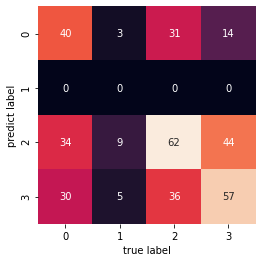

In [48]:
y_pred = lrf.predict(X_test_avarage_pixel_channels)
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');

print(classification_report(y_test, y_pred))

Our model prediction accuracy is better, the model failed to classify leaves as having 2 diseases, but that can be challenging because of our small images of this class. The 44% accuracy marks a big improvment over previous attempts, but doesn't gives us a real efficient working tool

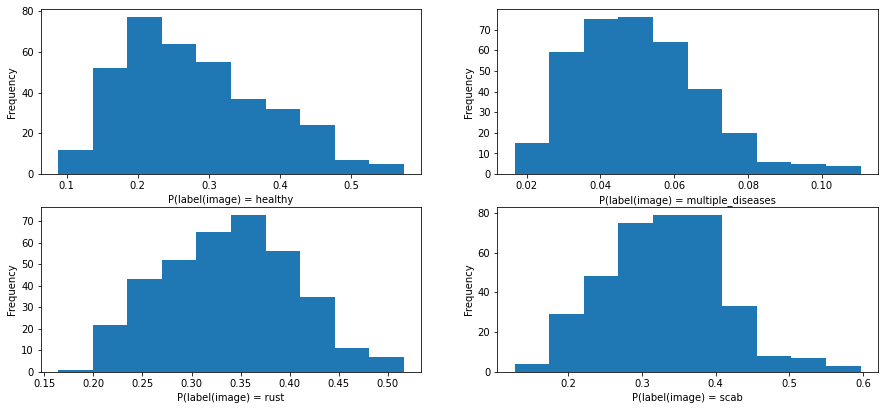

In [49]:
y_pred_prob = lrf.predict_proba(X_test_avarage_pixel_channels)

cols, rows = 2,2  
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for i in range(cols*rows):
  ax[int(i/cols), int(i%rows)].hist(y_pred_prob[:, i])
  plt.setp(ax[int(i/cols), int(i%rows)], xlabel=f'P(label(image) = {current_train_data.columns[i+1]}')
  plt.setp(ax[int(i/cols), int(i%rows)], ylabel='Frequency')
plt.show()

We can see that again the model classifies images with low degree of certainty, which indicate that our model is poor

## All Channel Values

Our last attempt at this method is to try it on all of the chnnels values 

In [50]:
lrf=LogisticRegression(max_iter=10000)
lrf.fit(X_train_2d,y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred = lrf.predict(X_test_2d)
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predict label');

print(classification_report(y_test, y_pred))

Our model on every channel value has decreased in accuracy. It again failed to classify currectly multy-diseased leaves.

In [ ]:
y_pred_prob = lrf.predict_proba(X_test_2d)

cols, rows = 2,2  
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for i in range(cols*rows):
  ax[int(i/cols), int(i%rows)].hist(y_pred_prob[:, i])
  plt.setp(ax[int(i/cols), int(i%rows)], xlabel=f'P(label(image) = {current_train_data.columns[i+1]}')
  plt.setp(ax[int(i/cols), int(i%rows)], ylabel='Frequency')
plt.show()

Even though our model had worse accurecy, we can see that its classification is much more decisive. most of the classifications are in the edges of the probability scale.


## Conclusion Thus Far

Our model, again, performs badly. We can infer that the problem is not as easy to solve as we thought at the begining. The logistic regression produces a model that does not classify images currectly. We guess that the main problem is that our data set is not cohesive enough: the brightness of the images differ greatly between images, the background has different color schemes, and over all the features that are importent are small in comparison to the whole image. Another problem in our data set could be the imbalances in groups.
In our future models we will try to incorporate more techniques that can handel those problems

#  **Multilayer perceptron Neural Network**

In our next attempts we will use a much more robust model, neural network. Neural networks is considered to be one of the most accurate model for image classification

First we will splits the data into train and test data

In [51]:
seed=1994
current_train_data=train_data.loc[train_images.index]
images_array=images_4d_array(train_images)
targets=get_target_array(current_train_data)
X_train, X_test, y_train, y_test = train_test_split(images_array, targets, test_size=0.2, random_state=seed)
X_train_2d=get_all_pixels(X_train)
X_test_2d=get_all_pixels(X_test)

In [52]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train_2d=get_all_pixels(X_train)
X_test_2d=get_all_pixels(X_test)

In [53]:
X_train_2d.shape

(1456, 30000)

Now we will build our multilayer perceptron, we chose to start with this model because it can produce good results for some problems and  doesn't take as much time as other models. Starting with less resource consuming option can be beneficial if this model would yields good results 

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 128
epochs = 10

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(30000,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15360512  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [56]:
history = model.fit(X_train_2d, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test_2d, y_test))

score = model.evaluate(X_test_2d, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
12/12 [==============================] - 1s 42ms/step - loss: 2.9828 - accuracy: 0.2081 - val_loss: 2.1880 - val_accuracy: 0.3178
Epoch 2/10
12/12 [==============================] - 0s 25ms/step - loss: 2.2848 - accuracy: 0.2370 - val_loss: 2.1875 - val_accuracy: 0.2548
Epoch 3/10
12/12 [==============================] - 0s 23ms/step - loss: 2.1932 - accuracy: 0.2328 - val_loss: 2.1874 - val_accuracy: 0.3452
Epoch 4/10
12/12 [==============================] - 0s 22ms/step - loss: 2.1684 - accuracy: 0.2720 - val_loss: 2.1874 - val_accuracy: 0.3452
Epoch 5/10
12/12 [==============================] - 0s 23ms/step - loss: 2.1641 - accuracy: 0.2692 - val_loss: 2.1873 - val_accuracy: 0.3452
Epoch 6/10
12/12 [==============================] - 0s 22ms/step - loss: 2.1617 - accuracy: 0.3029 - val_loss: 2.1872 - val_accuracy: 0.3452
Epoch 7/10
12/12 [==============================] - 0s 21ms/step - loss: 2.1606 - accuracy: 0.3043 - val_loss: 2.1872 - val_accuracy: 0.3452
Epoch 8/10
12

The model's accuracy is as good as our logistic regression. Our results are bad and we didn't produced a valid model

# **CNN-Convolution Neural Network**

Convolution neural network is the fittest and most robust model that we know of to this task. It will serve as our main tool in this classification task, thus we will prepare the ground before applying it

## Set Early Stopping Parameters

We have limited resources, and we want to make the most out of them. In order to do so, we set stopping parameters which determands that as the model reaching a plateau, the run will stop

In [57]:
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=10,
                            min_lr=.000001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)

reg = .0005

## Plot History Function

We will use this function to plot our model progression

In [161]:
def plot_history(history):

  h = history.history

  offset = 5
  epochs = range(offset, len(h['loss']))

  plt.figure(1, figsize=(20, 6))

  plt.subplot(121)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.plot(epochs, h['loss'][offset:], label='train')
  plt.plot(epochs, h['val_loss'][offset:], label='val')
  plt.legend()

  plt.subplot(122)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.plot(h[f'accuracy'], label='train')
  plt.plot(h[f'val_accuracy'], label='val')
  plt.legend()

  plt.show()

  from sklearn.metrics import roc_auc_score



  pred_test = model.predict(x_val)
  roc_sum = 0
  classes=['healthy',	'multiple_diseases',	'rust',	'scab']
  for i in range(4):
      score = roc_auc_score(y_val.iloc[:,i].values.astype('int32'), pred_test[:,i])
      roc_sum += score
      print(f'AUC-ROC {classes[i]}  {score:.3f}')

  roc_sum /= 4
  print(f'totally roc score:{roc_sum:.3f}')

## CNN Model

Now we will create a CNN model to our use

In [59]:
def creat_model(img_size):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Conv2D(128, kernel_size=(5,5),activation='relu', kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
  model.add(Dropout(.25))

  model.add(Conv2D(32, kernel_size=(3,3),activation='relu', kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
  model.add(Dropout(.25))


  model.add(Conv2D(128, kernel_size=(5,5),activation='relu', kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Conv2D(512, kernel_size=(5,5),activation='relu',kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
  model.add(Dropout(.25))

  model.add(Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Conv2D(512, kernel_size=(3,3),activation='relu',kernel_regularizer=l2(reg)))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(MaxPooling2D(pool_size=(2,2), padding='SAME'))
  model.add(Dropout(.25))

  model.add(Flatten())
  model.add(Dense(300,activation='relu'))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Dropout(.25))
  model.add(Dense(200,activation='relu'))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Dropout(.25))
  model.add(Dense(100,activation='relu'))
  model.add(BatchNormalization(axis=-1,center=True,scale=False))
  model.add(Dropout(.25))
  model.add(Dense(4,activation='softmax'))

  model.summary()
 
  
  return model

## First Attempt- 100x100 Image Size


We will make 100 by 100 pixel images


In [60]:
train_100X100_images = train_data["image_id"].progress_apply(load_image, args=((100,100),))

Now we will splits the data into train and test data

In [68]:
targets=current_train_data.drop('image_id',axis=1)

In [155]:
current_train_data=train_data.loc[train_100X100_images.index]
images_array=images_4d_array(train_100X100_images)
targets=current_train_data.drop('image_id',axis=1)
x_train, x_val, y_train, y_val = train_test_split(images_array, targets, test_size=0.2, random_state=seed)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1456, 100, 100, 3), (365, 100, 100, 3), (1456, 4), (365, 4))

Running the model on 100x100 images

In [142]:
model = creat_model(100)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 96, 96, 32)        2432      
_________________________________________________________________
batch_normalization_66 (Batc (None, 96, 96, 32)        96        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 92, 92, 128)       102528    
_________________________________________________________________
batch_normalization_67 (Batc (None, 92, 92, 128)       384       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 46, 46, 128)       0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 44, 44, 32)       

In [143]:
history = model.fit(x_train,
                    y_train,
                    batch_size=24,
                    epochs=250,
                    steps_per_epoch=x_train.shape[0] // 24,
                    verbose=1,
                    callbacks=[ES_monitor,LR_reduce],
                    validation_data=(x_val, y_val),
                    validation_steps=x_val.shape[0]//24
                    )

Epoch 1/250
60/60 [==============================] - 9s 148ms/step - loss: 2.3189 - accuracy: 0.3090 - val_loss: 3.1088 - val_accuracy: 0.3250
Epoch 2/250
60/60 [==============================] - 8s 141ms/step - loss: 2.1146 - accuracy: 0.3177 - val_loss: 6.0162 - val_accuracy: 0.2861
Epoch 3/250
60/60 [==============================] - 8s 140ms/step - loss: 1.9826 - accuracy: 0.3436 - val_loss: 3.8783 - val_accuracy: 0.3250
Epoch 4/250
60/60 [==============================] - 8s 140ms/step - loss: 1.8383 - accuracy: 0.3575 - val_loss: 3.4593 - val_accuracy: 0.2778
Epoch 5/250
60/60 [==============================] - 8s 140ms/step - loss: 1.7667 - accuracy: 0.3652 - val_loss: 1.8779 - val_accuracy: 0.3944
Epoch 6/250
60/60 [==============================] - 8s 140ms/step - loss: 1.6531 - accuracy: 0.3855 - val_loss: 1.9960 - val_accuracy: 0.3500
Epoch 7/250
60/60 [==============================] - 8s 140ms/step - loss: 1.6175 - accuracy: 0.3757 - val_loss: 1.8127 - val_accuracy: 0.3917

12/12 [==============================] - 1s 46ms/step - loss: 0.6939 - accuracy: 0.8685
Test loss: 0.6938706040382385
Test accuracy: 0.8684931397438049


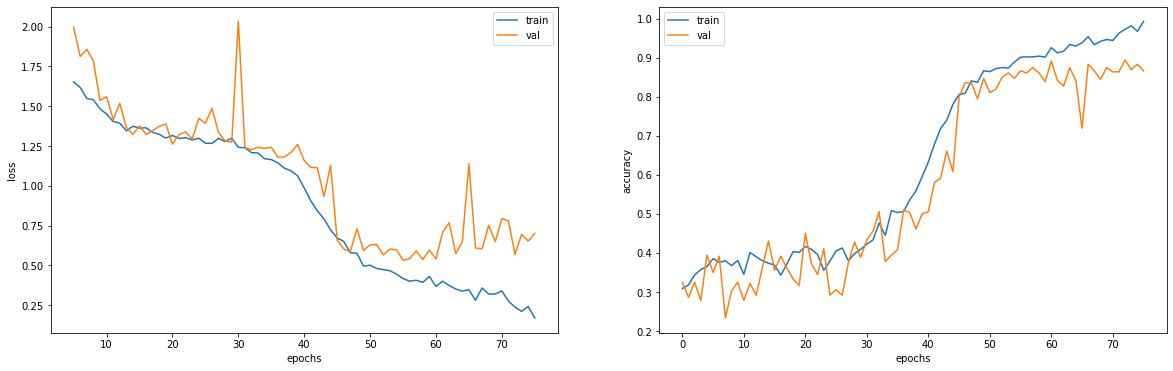

AUC-ROC healthy  0.979
0.979
AUC-ROC multiple_diseases  0.689
0.689
AUC-ROC rust  0.982
0.982
AUC-ROC scab  0.979
0.979
totally roc score:0.907


In [144]:
score = model.evaluate(x_val, y_val, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Our accuracy has improved drastically to 87%, but we think that we could do better






In [145]:
model.save("model_100X100.h5")
model = load_model('model_100X100.h5')

## Second Attempt- 224x224 Image Size


In [146]:
img_size = 224

In [147]:
train_224X224_images = train_data["image_id"].progress_apply(load_image, args=((img_size,img_size),))

In [156]:
current_train_data=train_data.loc[train_224X224_images.index]
images_array=images_4d_array(train_224X224_images)
targets=current_train_data.drop('image_id',axis=1)
x_train2, x_val, y_train2, y_val = train_test_split(images_array, targets, test_size=0.2, random_state=seed)
x_train2 = x_train2.astype('float32')
x_val = x_val.astype('float32')
x_train2 /= 255
x_val /= 255
x_train2.shape, x_val.shape, y_train2.shape, y_val.shape

((1456, 224, 224, 3), (365, 224, 224, 3), (1456, 4), (365, 4))

Running the model on 224x224 images

In [157]:
model = creat_model(img_size)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_88 (Batc (None, 220, 220, 32)      96        
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 216, 216, 128)     102528    
_________________________________________________________________
batch_normalization_89 (Batc (None, 216, 216, 128)     384       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 108, 108, 128)     0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 108, 108, 128)     0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 106, 106, 32)     

In [152]:
x_train2.shape

(1456, 100, 100, 3)

In [158]:
history = model.fit(x_train2,
                    y_train2,
                    batch_size=24,
                    epochs=250,
                    steps_per_epoch=x_train2.shape[0] // 24,
                    verbose=1,
                    callbacks=[ES_monitor,LR_reduce],
                    validation_data=(x_val, y_val),
                    validation_steps=x_val.shape[0]//24
                    )

Epoch 1/250
60/60 [==============================] - 39s 658ms/step - loss: 2.3199 - accuracy: 0.3090 - val_loss: 3.1141 - val_accuracy: 0.3250
Epoch 2/250
60/60 [==============================] - 39s 647ms/step - loss: 2.0630 - accuracy: 0.3401 - val_loss: 1.8818 - val_accuracy: 0.2750
Epoch 3/250
60/60 [==============================] - 39s 642ms/step - loss: 1.9207 - accuracy: 0.3240 - val_loss: 8.3608 - val_accuracy: 0.2667
Epoch 4/250
60/60 [==============================] - 39s 643ms/step - loss: 1.6551 - accuracy: 0.3631 - val_loss: 3.3544 - val_accuracy: 0.2694
Epoch 5/250
60/60 [==============================] - 39s 642ms/step - loss: 1.5873 - accuracy: 0.3387 - val_loss: 1.7104 - val_accuracy: 0.3861
Epoch 6/250
60/60 [==============================] - 39s 643ms/step - loss: 1.4968 - accuracy: 0.3561 - val_loss: 1.4952 - val_accuracy: 0.3556
Epoch 7/250
60/60 [==============================] - 38s 641ms/step - loss: 1.4506 - accuracy: 0.3666 - val_loss: 1.5766 - val_accuracy:

In [159]:
score = model.evaluate(x_val, y_val, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 3s 275ms/step - loss: 0.9541 - accuracy: 0.7671
Test loss: 0.9540842771530151
Test accuracy: 0.767123281955719


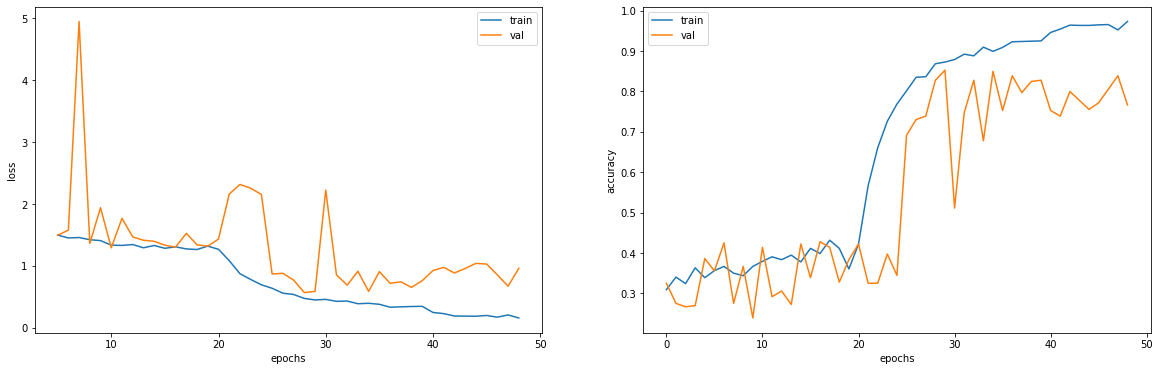

AUC-ROC healthy  0.965
AUC-ROC multiple_diseases  0.687
AUC-ROC rust  0.974
AUC-ROC scab  0.949
totally roc score:0.894


In [162]:
plot_history(history)

In this  model our accuracy has decreased , it seems that the small smaple size of the mulli-diseased class has effected the model. this class AUC-ROC is significantly smaller then the other classes. We can also see that from a certain point the model starts to over fit the train dataset, it can be seen by the increasing gap between the 2 accuracy plots. We would need to change something if we want to get a better model

In [163]:
model.save("model_224X224.h5")
model = load_model('model_224X224.h5')

## Data Transformations and Augmentation

Image transformations and augmentation is an efficient way to diversify data and to generalize a model

We will use a built in function to do so, and we will change images rotation, orientation, brightness and scale

 

In [164]:
datagen = ImageDataGenerator(rotation_range=45,
                             shear_range=.25,
                              zoom_range=.25,
                              width_shift_range=.25,
                              height_shift_range=.25,
                              rescale=1/255,
                              brightness_range=[.5,1.5],
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest'
#                              featurewise_center=True,
#                              samplewise_center=True,
#                              featurewise_std_normalization=True,
#                              samplewise_std_normalization=True,
#                              zca_whitening=True
                              )

Running the model on 224x224 images with the transformations and augmentation

In [165]:
model = creat_model(img_size)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_99 (Batc (None, 220, 220, 32)      96        
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 216, 216, 128)     102528    
_________________________________________________________________
batch_normalization_100 (Bat (None, 216, 216, 128)     384       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 108, 108, 128)     0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 108, 108, 128)     0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 106, 106, 32)    

In [167]:
history = model.fit_generator(datagen.flow(x_train2, y_train2, batch_size=24),
                              epochs=250,
                              steps_per_epoch=x_train2.shape[0] // 24,
                              verbose=1,
                              callbacks=[ES_monitor,LR_reduce],
                              validation_data=datagen.flow(x_val, y_val,batch_size=24),
                              validation_steps=x_val.shape[0]//24
                              )

Epoch 1/250
60/60 [==============================] - 42s 694ms/step - loss: 1.3247 - accuracy: 0.3464 - val_loss: 1.3156 - val_accuracy: 0.3472
Epoch 2/250
60/60 [==============================] - 42s 694ms/step - loss: 1.2985 - accuracy: 0.3373 - val_loss: 1.3467 - val_accuracy: 0.2667
Epoch 3/250
60/60 [==============================] - 42s 695ms/step - loss: 1.2937 - accuracy: 0.3757 - val_loss: 1.3106 - val_accuracy: 0.3472
Epoch 4/250
60/60 [==============================] - 42s 697ms/step - loss: 1.3008 - accuracy: 0.3422 - val_loss: 1.3205 - val_accuracy: 0.3139
Epoch 5/250
60/60 [==============================] - 42s 696ms/step - loss: 1.3055 - accuracy: 0.3485 - val_loss: 1.3135 - val_accuracy: 0.3278
Epoch 6/250
60/60 [==============================] - 42s 697ms/step - loss: 1.2996 - accuracy: 0.3303 - val_loss: 1.4409 - val_accuracy: 0.2917
Epoch 7/250
60/60 [==============================] - 42s 698ms/step - loss: 1.2847 - accuracy: 0.3687 - val_loss: 1.4742 - val_accuracy:

In [168]:
score = model.evaluate(x_val, y_val, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 2s 167ms/step - loss: 0.2401 - accuracy: 0.9370
Test loss: 0.24010302126407623
Test accuracy: 0.9369863271713257


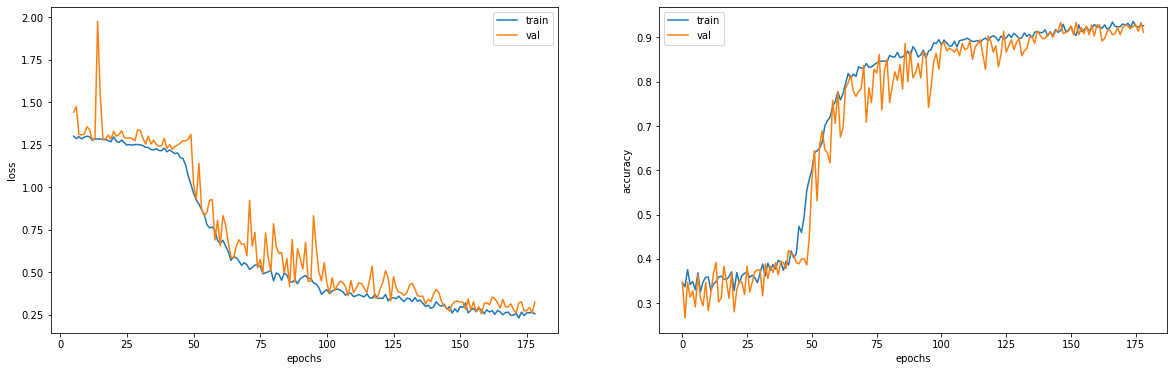

AUC-ROC healthy  0.995
AUC-ROC multiple_diseases  0.865
AUC-ROC rust  0.994
AUC-ROC scab  0.995
totally roc score:0.962


In [169]:
plot_history(history)

Our accuracy has improved drastically to 93%, a great accomplishment. we can see that the vlidation and test scores are similar which can show that the model didn't overpitted to the test. but can we do better? We know that our imbalanced datd effected our prediction before, we should try to address it

In [170]:
model.save("model_224X224_image_generate.h5")
model = load_model('model_224X224_image_generate.h5')

## Handling Imbalanced in Our Dataset -SMOTE


We'll be applying Synthetic Minority Oversampling Technique ( [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/))¶ The function will add us examples of the minority class 


 Lets check its affect on our dataset. The size of our dataset before running the function

In [177]:
print(x_train2.shape,y_train2.shape)

(1456, 224, 224, 3) (1456, 4)


Applying SMOTE on our dataset

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 115) 
 
x_train2, y_train2 = sm.fit_resample(np.array(get_all_pixels(x_train2),dtype = np.float32), np.array(y_train2))
x_train2 = x_train2.reshape((-1, img_size, img_size, 3))
x_train2.shape, y_train2.sum(axis=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



We see that we have added almost 600 examples,most of them to the minority class, and our data is balance

Let's try to fit the CNN to the new dataset

In [ ]:
model = creat_model(img_size)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
history = model.fit_generator(datagen.flow(x_train2, y_train2, batch_size=24),
                              epochs=250,
                              steps_per_epoch=x_train2.shape[0] // 24,
                              verbose=1,
                              callbacks=[ES_monitor,LR_reduce],
                              validation_data=datagen.flow(x_val, y_val,batch_size=24),
                              validation_steps=x_val.shape[0]//24
                              )

In [ ]:
score = model.evaluate(x_val, y_val, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plot_history(history)

Our accuracy has improved in more then a precent to 96%, an impressive improvement in this range, but did we really improved?

In [ ]:
model.save("model_224X224_smoth.h5")
model = load_model('model_224X224_smoth.h5')

# **What's Next?**

We feel that we made great improvment on our dataset, but we didn't considered one importemt thing, overfitting. In every model we used the same sample as validation and test, which make our results not that impressive, we didn't took it in consideration while working on the project thus far. We are planning on comparing our results on data that has no classification with the winners of the kaggle challenge, or to split our data in advence to 3 groups. In addition we want to try to use pre-trained state of the art model and check if it will performe better.